# Example 04: Optical Raytracing (Advanced)

This example demonstrates advanced coordinate frame usage in optical raytracing. We'll trace parallel rays through lens surfaces and see how frame transformations simplify optical system design.

**Prerequisites**: Basic optics (Snell's Law), numerical methods  
**Skip ahead**: See "TL;DR" section below for the key insight

**Key demonstrations**:
1. **Frame transformations simplify optics**: Position/rotate lenses by modifying frames - the raytracing algorithm stays unchanged
2. **Meridional plane reduction**: Transform 3D intersection problem to 2D by exploiting rotational symmetry
3. **Interchangeable profiles**: Swap optical surfaces (spherical, hyperbolic) without changing the tracing code

**Note**: This is a simplified raytracer for demonstration. Production implementations would handle:
  - Rays missing the surface (returns error instead of graceful fallback)
  - Rays starting inside the surface
  - Numerical stability near grazing incidence

## TL;DR - The Key Insight

If you're skipping the technical details, here's what matters:

**Scenario**: We want to trace light rays through a lens. The lens can be perfectly aligned or tilted at some angle.

**The traditional approach**: Manually rotate all geometric calculations - intersection points, surface normals, ray directions - every time you change the lens orientation. Error-prone and tedious.

**The hazy approach**: Put the lens in its own coordinate frame. All geometric calculations happen in the lens's local frame. Want to tilt the lens 5°? Change **one line**:

```python
# Aligned lens
lens_frame = root.make_child("lens").translate(x=-25)

# Tilted lens - ONLY the frame definition changes!
lens_frame = root.make_child("lens").translate(x=-25).rotate_euler(y=5, degrees=True)
```

The entire raytracing algorithm (intersection finding, refraction, propagation) stays **completely unchanged**. Scroll down to see this in action with spherical and hyperbolic lenses.

---

## Setup

In [1]:
from __future__ import annotations

from collections import defaultdict
from dataclasses import dataclass, field
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import brentq

from hazy import Frame, Point, Vector

## Define optical primitives

We need classes for rays, ray history tracking, and axisymmetric surfaces (rotationally symmetric around the optical axis).

In [2]:
@dataclass
class RayState:
    """Snapshot of ray state at a point in space.

    Args:
        point: Position in global coordinates
        direction: Direction vector in global coordinates
    """

    point: Point
    direction: Vector


@dataclass
class RayHistory:
    """Tracks ray trajectory through optical system."""

    history: list[RayState] = field(default_factory=list)

    def append(self, ray: Ray) -> RayHistory:
        """Add ray state to history (converts to global coordinates).

        Args:
            ray: Ray to record

        Returns:
            Self for method chaining
        """
        self.history.append(
            RayState(point=ray.origin.to_global(), direction=ray.direction.to_global())
        )
        return self

    def plot(self, ax, **plot_args):
        """Plot ray trajectory.

        Args:
            ax: Matplotlib 3D axis
            **plot_args: Additional plotting arguments (color, linewidth, etc.)
        """
        points = np.array([p.point for p in self.history])
        ax.plot(*points.T, **plot_args)


@dataclass(frozen=True)
class Ray:
    """Immutable ray with origin and direction.

    Rays are geometric primitives similar to Points and Vectors.
    All operations return new Ray instances.

    Args:
        origin: Ray starting point
        direction: Ray direction (automatically normalized)
    """

    origin: Point
    direction: Vector

    def __post_init__(self):
        object.__setattr__(self, "direction", self.direction.copy().normalize())

    def to_frame(self, frame: Frame) -> Ray:
        """Transform ray to different coordinate frame.

        Args:
            frame: Target coordinate frame

        Returns:
            New ray in target frame
        """
        return Ray(
            origin=self.origin.to_frame(frame), direction=self.direction.to_frame(frame)
        )

    def to_global(self) -> Ray:
        """Transform ray to global coordinates.

        Returns:
            New ray in global frame
        """
        return Ray(origin=self.origin.to_global(), direction=self.direction.to_global())

    def propagate(self, t: float) -> Ray:
        """Propagate ray along direction.

        Args:
            t: Distance to propagate

        Returns:
            New ray at propagated position
        """
        return Ray(origin=self.origin + self.direction * t, direction=self.direction)

    def refract(self, normal: Vector, n1: float, n2: float) -> Ray | None:
        """Refract ray at surface using Snell's law (vector form).

        Args:
            normal: Surface normal (pointing toward incident medium)
            n1: Refractive index of incident medium
            n2: Refractive index of transmitted medium

        Returns:
            Refracted ray, or None if total internal reflection

        Examples:
            >>> ray_refracted = ray.refract(normal, n1=1.0, n2=1.5)
        """
        normal = normal.to_frame(self.direction.frame).copy().normalize()

        ratio = n1 / n2
        cos_i = -self.direction.dot(normal)

        # Flip normal if ray hits from behind
        if cos_i < 0:
            normal = -normal
            cos_i = -cos_i

        sin2_t = ratio**2 * (1 - cos_i**2)

        # Total internal reflection
        if sin2_t > 1:
            return None

        cos_t = np.sqrt(1 - sin2_t)

        # Snell's law (vector form)
        d_refracted = ratio * self.direction + (ratio * cos_i - cos_t) * normal

        return Ray(
            origin=self.origin.copy(), direction=self.origin.frame.vector(d_refracted)
        )

In [3]:
@dataclass
class AxisymmetricSurface:
    """Rotationally symmetric surface defined by 1D profile x = f(r).

    Coordinate system:
    - x: optical axis
    - r = sqrt(y^2 + z^2): radial distance from axis

    The surface is created by revolving the 2D profile around the x-axis.

    Args:
        frame: Local coordinate frame of the surface
        profile: Function mapping radial distance to axial position: x = f(r)
        aperture_radius: Maximum radial extent of the surface
        profile_derivative: Optional derivative dx/dr for faster normal computation
    """

    frame: Frame
    profile: Callable[[np.ndarray], np.ndarray]
    aperture_radius: float
    profile_derivative: Callable[[np.ndarray], np.ndarray] | None = None

    def evaluate(self, r: np.ndarray) -> np.ndarray:
        """Evaluate profile at radial positions.

        Args:
            r: Radial distance(s) from optical axis

        Returns:
            Axial position(s) x = f(r)
        """
        return self.profile(np.asarray(r))

    def intersect(self, ray: Ray) -> tuple[float, Point, Vector] | None:
        """Find ray-surface intersection.

        Strategy: Transform to meridional plane to reduce 3D problem to 2D.
        The meridional plane contains the optical axis (x) and the ray origin.
        In this plane, we only need to solve for the axial coordinate x.

        Args:
            ray: Incident ray

        Returns:
            Tuple of (propagation distance, intersection point, surface normal)
            or None if no intersection exists
        """
        local_ray = ray.to_frame(self.frame)

        # Create meridional plane: contains optical axis and ray origin
        # This reduces the 3D intersection to a 2D problem (x, y_meridional)
        phi = np.arctan2(local_ray.origin.z, local_ray.origin.y)
        meridional = self.frame.make_child("meridional").rotate_euler(x=phi)
        meri_ray = ray.to_frame(meridional)

        # In meridional plane: only solve for x coordinate
        def objective_function(t: float) -> float:
            y = meri_ray.origin.y + t * meri_ray.direction.y
            r = abs(y)

            if r > self.aperture_radius:
                return 1e10 if t > 0 else -1e10

            x_ray = meri_ray.origin.x + t * meri_ray.direction.x
            x_surface = self.profile(np.array([r]))[0]

            if np.isnan(x_surface):
                return 1e10 if t > 0 else -1e10

            return x_ray - x_surface

        # Use bracketing method (robust for 1D problems)
        # Search for sign change between t=0 and t=100
        try:
            t_hit, res = brentq(
                objective_function, 0.1, 100.0, xtol=1e-10, full_output=True
            )
        except ValueError:
            return None

        propagated_ray = meri_ray.propagate(t_hit)
        hit_local = propagated_ray.origin.to_frame(self.frame)

        # Compute surface normal in local frame
        normal_local = self.normal_at(hit_local)

        return t_hit, hit_local, normal_local

    def normal_at(self, point: Point) -> Vector:
        """Compute outward surface normal at point.

        Args:
            point: Surface point (in surface frame)

        Returns:
            Outward-pointing unit normal vector
        """
        p = point.to_frame(self.frame)
        r = np.sqrt(p.y**2 + p.z**2)

        # On-axis: normal points along -x
        if r < 1e-12:
            return self.frame.vector(-1.0, 0.0, 0.0)

        # Compute derivative dx/dr
        if self.profile_derivative is not None:
            dxdr = self.profile_derivative(np.array([r]))[0]
        else:
            # Numerical derivative
            eps = 1e-8
            dxdr = (
                self.profile(np.array([r + eps]))[0]
                - self.profile(np.array([r - eps]))[0]
            ) / (2 * eps)

        # Normal in cylindrical coordinates: (-1, dx/dr * y/r, dx/dr * z/r)
        return self.frame.vector(-1.0, dxdr * p.y / r, dxdr * p.z / r).normalize()

    def plot_profile(self, ax=None, n_points: int = 500, **kwargs):
        """Plot 2D profile in meridional plane.

        Args:
            ax: Matplotlib axis (creates new if None)
            n_points: Number of points to plot
            **kwargs: Additional plot arguments

        Returns:
            Matplotlib axis
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))

        y = np.linspace(-self.aperture_radius, self.aperture_radius, n_points)
        x = self.profile(np.abs(y))

        defaults = {"linewidth": 2}
        defaults.update(kwargs)
        ax.plot(x, y, **defaults)

        ax.set_xlabel("x (optical axis)")
        ax.set_ylabel("y (radial)")
        ax.set_aspect("equal")
        ax.grid(True, alpha=0.3)

        return ax

    def plot_surface(
        self, ax=None, n_radial: int = 50, n_azimuthal: int = 60, **surface_kwargs
    ):
        """Plot revolved 3D surface.

        Args:
            ax: Matplotlib 3D axis (creates new if None)
            n_radial: Number of radial sample points
            n_azimuthal: Number of azimuthal sample points
            **surface_kwargs: Additional surface plot arguments

        Returns:
            Matplotlib 3D axis
        """
        if ax is None:
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection="3d")

        # Generate surface mesh
        r = np.linspace(0, self.aperture_radius, n_radial)
        phi = np.linspace(0, 2 * np.pi, n_azimuthal)
        r_grid, phi_grid = np.meshgrid(r, phi)

        # Convert to Cartesian in surface frame
        y_grid = r_grid * np.cos(phi_grid)
        z_grid = r_grid * np.sin(phi_grid)
        x_grid = self.profile(r_grid)

        shape = x_grid.shape

        # Transform to global coordinates
        x, y, z = self.frame.batch_transform_points_global(
            np.stack([x_grid.ravel(), y_grid.ravel(), z_grid.ravel()], axis=-1)
        ).T

        defaults = {"alpha": 0.3, "edgecolor": "none"}
        defaults.update(surface_kwargs)
        ax.plot_surface(
            x.reshape(shape), y.reshape(shape), z.reshape(shape), **defaults
        )

        ax.set_xlabel("x (optical axis)")
        ax.set_ylabel("y")
        ax.set_zlabel("z")

        return ax

## Surface profile functions

Optical surfaces are defined by 1D profiles `x = f(r)` that are revolved around the x-axis (optical axis).

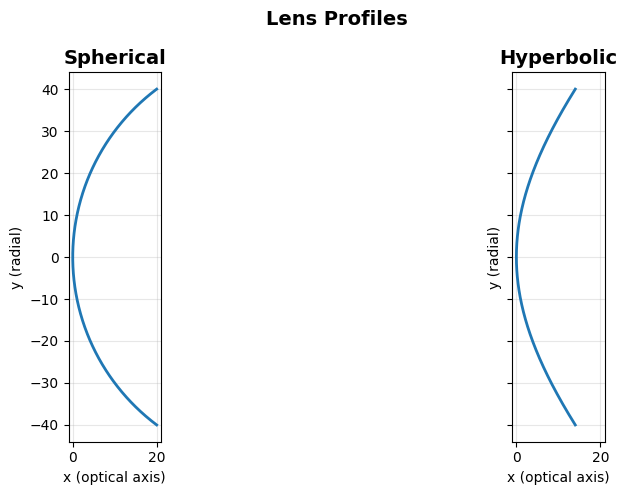

In [4]:
def spherical_profile(
    R: float,
) -> tuple[Callable[[np.ndarray], np.ndarray], Callable[[np.ndarray], np.ndarray]]:
    """Create spherical surface profile and its derivative.

    Args:
        R: Radius of curvature
           R > 0: convex (bulging toward +x)
           R < 0: concave (bulging toward -x)

    Returns:
        Tuple of (profile function, derivative function)

    Examples:
        >>> profile, deriv = spherical_profile(R=50)
        >>> x = profile(np.array([0, 10, 20]))  # x positions at r = 0, 10, 20
    """

    def profile(r: np.ndarray) -> np.ndarray:
        r = np.asarray(r)
        arg = R**2 - r**2
        valid = arg >= 0
        x = np.full_like(r, np.nan, dtype=float)
        x[valid] = R - np.sign(R) * np.sqrt(arg[valid])
        return x

    def derivative(r: np.ndarray) -> np.ndarray:
        r = np.asarray(r)
        arg = R**2 - r**2
        valid = arg > 0
        dxdr = np.full_like(r, np.nan, dtype=float)
        dxdr[valid] = r[valid] / (np.sign(R) * np.sqrt(arg[valid]))
        return dxdr

    return profile, derivative


def hyperbolic_profile(
    R: float, conic_constant: float = -2.0
) -> tuple[Callable[[np.ndarray], np.ndarray], Callable[[np.ndarray], np.ndarray]]:
    """Create hyperbolic surface profile and its derivative.

    General conic surface: x = (r^2/R) / (1 + sqrt(1 - (1+K)*(r/R)^2))
    where K is the conic constant.

    For K < -1: hyperbola (stronger curvature at edges than sphere)
    For K = -1: parabola
    For -1 < K < 0: ellipse
    For K = 0: sphere

    Args:
        R: Radius of curvature at apex (r=0)
        conic_constant: K value (default -2.0 for hyperbola)

    Returns:
        Tuple of (profile function, derivative function)

    Examples:
        >>> profile, deriv = hyperbolic_profile(R=25, conic_constant=-2.0)
        >>> x = profile(np.array([0, 10, 20]))
    """

    def profile(r: np.ndarray) -> np.ndarray:
        r = np.asarray(r)
        r2 = r**2
        arg = 1 - (1 + conic_constant) * r2 / (R**2)

        valid = arg > 0
        x = np.full_like(r, np.nan, dtype=float)
        x[valid] = r2[valid] / (R * (1 + np.sqrt(arg[valid])))
        return x

    def derivative(r: np.ndarray) -> np.ndarray:
        r = np.asarray(r)
        r2 = r**2
        arg = 1 - (1 + conic_constant) * r2 / (R**2)

        valid = arg > 0
        dxdr = np.full_like(r, np.nan, dtype=float)

        sqrt_arg = np.sqrt(arg[valid])
        denominator = R * (1 + sqrt_arg) ** 2
        numerator = (
            2
            * r[valid]
            * (1 + sqrt_arg + (1 + conic_constant) * r2[valid] / (2 * R**2 * sqrt_arg))
        )

        dxdr[valid] = numerator / denominator
        return dxdr

    return profile, derivative


fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 5))
fig.suptitle("Lens Profiles", fontsize=14, fontweight="bold")
root = Frame.make_root("dummy-frame")

axs[0].set_title("Spherical", fontsize=14, fontweight="bold")
profile, profile_derivative = spherical_profile(R=50)
AxisymmetricSurface(
    frame=root,
    profile=profile,
    profile_derivative=profile_derivative,
    aperture_radius=40,
).plot_profile(axs[0])

axs[1].set_title("Hyperbolic", fontsize=14, fontweight="bold")
profile, profile_derivative = hyperbolic_profile(R=50)
AxisymmetricSurface(
    frame=root,
    profile=profile,
    profile_derivative=profile_derivative,
    aperture_radius=40,
).plot_profile(axs[1])

plt.tight_layout()

## Raytracing function

This function traces parallel rays through a surface, showing the 3D trajectory and final footprint.

In [5]:
def trace_rays_through_surface(
    surface: AxisymmetricSurface,
    n_rays: int = 10,
    inner_radius: float = 10.0,
    outer_radius: float = 22.0,
    n1: float = 1.0,
    n2: float = 1.5,
    final_x: float = 33.0,
) -> tuple[dict[int, RayHistory], tuple]:
    """Trace parallel rays through an optical surface.

    Args:
        surface: Optical surface to trace through
        n_rays: Number of rays to trace
        inner_radius: Radial distance of inner ray bundle from optical axis
        outer_radius: Radial distance of outer ray bundle from optical axis
        n1: Refractive index before surface
        n2: Refractive index after surface
        final_x: Final x position to propagate rays to

    Returns:
        Tuple of (ray histories dict, (fig, ax_3d, ax_2d))
    """
    fig = plt.figure(figsize=(14, 6))
    ax_3d = fig.add_subplot(121, projection="3d")
    ax_2d = fig.add_subplot(122)

    # Plot surface
    surface.plot_surface(ax_3d)
    ax_3d.set_title("3D Ray Trace", fontsize=14, fontweight="bold")
    ax_3d.set_xlim(-30, 30)
    ax_3d.set_ylim(-30, 30)
    ax_3d.set_zlim(-30, 30)

    # Generate rays in circular pattern
    phis = np.linspace(0, 2 * np.pi, n_rays, endpoint=False)

    for radius, cmap in zip([inner_radius, outer_radius], [plt.cm.Blues, plt.cm.Reds]):
        rays = defaultdict(RayHistory)
        colors = cmap(np.linspace(0.3, 0.9, n_rays))
        for i, phi in enumerate(phis):
            z = radius * np.cos(phi)
            y = radius * np.sin(phi)

            # Create initial ray
            ray = Ray(surface.frame.root.point(-30, y, z), surface.frame.root.x_axis)
            rays[i].append(ray)

            # Intersect with surface
            t, point, normal = surface.intersect(ray)
            ray = ray.propagate(t)
            rays[i].append(ray)

            # Refract at surface
            ray = ray.refract(normal, n1, n2)
            rays[i].append(ray)

            # Propagate after refraction
            final_x_point = (
                surface.frame.root.origin + surface.frame.root.x_axis * final_x
            )
            propagation_distance = surface.frame.root.x_axis.dot(
                final_x_point - ray.origin
            ) / surface.frame.root.x_axis.dot(ray.direction)
            ray = ray.propagate(propagation_distance)

            rays[i].append(ray)

        for (i, ray_history), color in zip(rays.items(), colors):
            ray_history.plot(ax_3d, c=color, linewidth=2, alpha=0.8)

            # Plot start and end points in 2D (y-z plane)
            ax_2d.scatter(
                *ray_history.history[0].point[[1, 2]],
                color=color,
                s=80,
                alpha=0.3,
                edgecolors="none",
            )
            ax_2d.scatter(
                *ray_history.history[-1].point[[1, 2]],
                color=color,
                s=80,
                edgecolors="white",
                linewidth=1.5,
            )

    ax_2d.set_aspect("equal")
    ax_2d.set_xlabel("y", fontsize=12)
    ax_2d.set_ylabel("z", fontsize=12)
    ax_2d.set_title(
        "Ray Footprint (start: faded, end: solid)", fontsize=14, fontweight="bold"
    )
    ax_2d.grid(True, alpha=0.3)

    return rays, (fig, ax_3d, ax_2d)

## Example: Raytracing a lens

This example demonstrates how coordinate frame transformations simplify optical raytracing.

We'll trace parallel rays through a spherical lens surface and observe spherical aberration - rays at different radial distances focus at different points.

The key insight: by placing the lens in its own coordinate frame, we can **reposition and reorient the entire optical system by changing a single line of code**, while all geometric calculations remain unchanged.

### Create root frame

In [6]:
root = Frame.make_root("root")

### Aligned spherical lens

Start with a perfectly aligned spherical lens. Notice the **spherical aberration**: rays at different radial distances don't focus to the same point - the footprint spreads out.

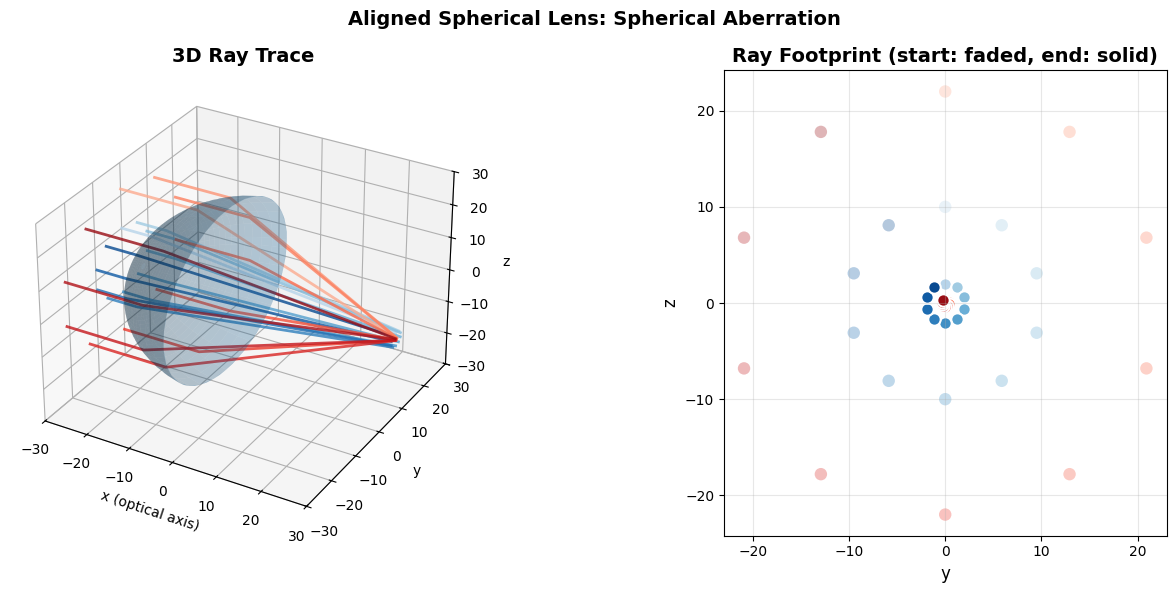

In [7]:
lens_frame = root.make_child("lens").translate(x=-25)

profile, derivative = spherical_profile(R=25)

surface = AxisymmetricSurface(
    frame=lens_frame,
    profile=profile,
    profile_derivative=derivative,
    aperture_radius=40.0,
)

rays, (fig, ax_3d, ax_2d) = trace_rays_through_surface(surface)

fig.suptitle(
    "Aligned Spherical Lens: Spherical Aberration", fontsize=14, fontweight="bold"
)
plt.tight_layout()

### Misalign the lens - only one line changes!

Now rotate the lens 5 degrees around the y-axis. **Look closely**: Only the `lens_frame` definition changes - the entire raytracing algorithm (intersection, refraction, propagation) stays identical.

This asymmetry creates **coma aberration** - the ray footprint becomes comet-shaped. This is a fundamental optical aberration that occurs when lenses are tilted.

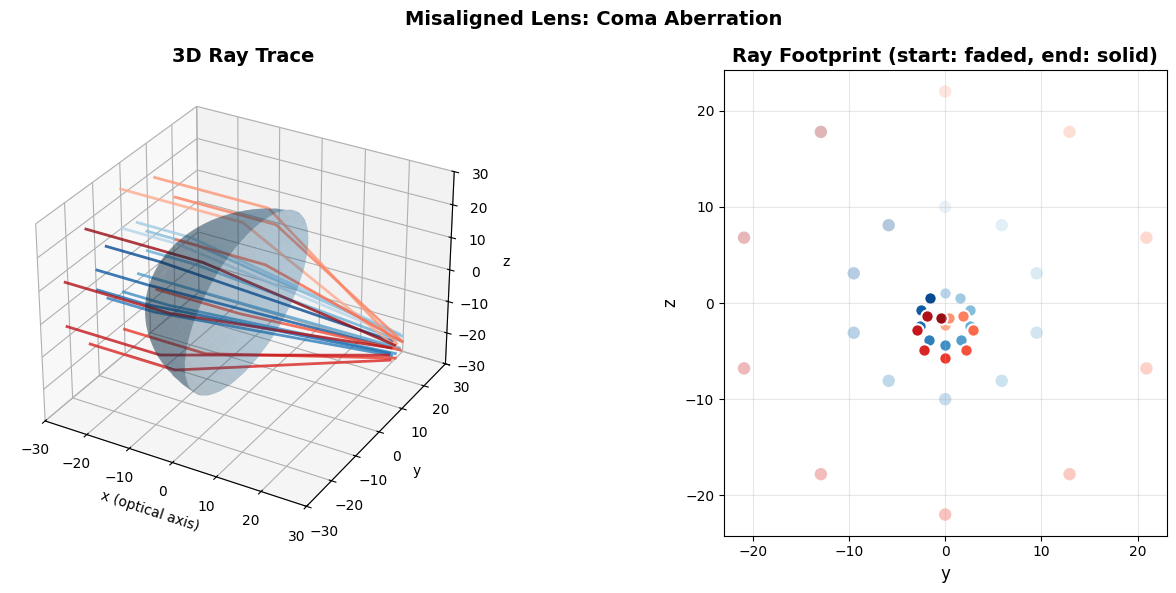

In [8]:
# Misaligned case: lens rotated 5 degrees
# ↓↓↓ ONLY THIS LINE CHANGES - everything else is identical! ↓↓↓
lens_frame = root.make_child("lens").translate(x=-20).rotate_euler(y=5, degrees=True)

profile, derivative = spherical_profile(R=25)

surface = AxisymmetricSurface(
    frame=lens_frame,
    profile=profile,
    profile_derivative=derivative,
    aperture_radius=40.0,
)

rays, (fig, ax_3d, ax_2d) = trace_rays_through_surface(surface)

fig.suptitle("Misaligned Lens: Coma Aberration", fontsize=14, fontweight="bold")
plt.tight_layout()

### Swap the surface profile - only the profile changes!

Replace the spherical lens with a hyperbolic one. Again, **only the profile function changes** - frame setup and raytracing code stay identical.

Hyperbolic surfaces (conic constant K < -1) have stronger edge curvature than spheres, which affects how rays are focused. Compare the footprint pattern to the spherical case above.

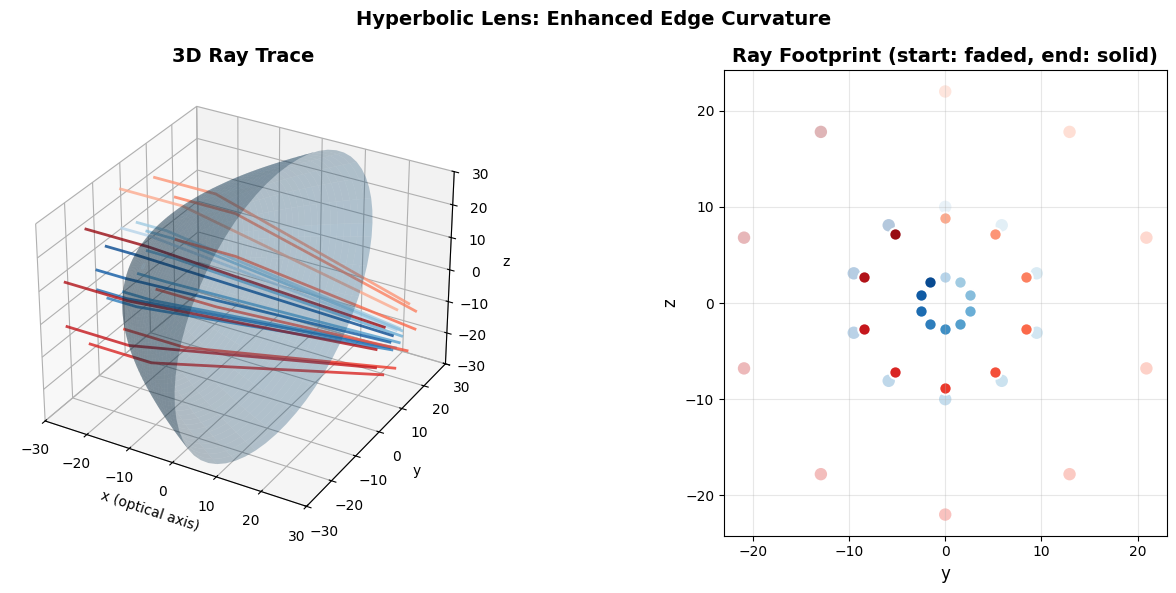

In [9]:
# Hyperbolic lens: different aberration characteristics
# ↓↓↓ ONLY THE PROFILE CHANGES - frame, raytracing, everything else identical! ↓↓↓
lens_frame = root.make_child("hyperbolic_lens").translate(x=-25)

profile, derivative = hyperbolic_profile(R=25, conic_constant=-1.0)

surface = AxisymmetricSurface(
    frame=lens_frame,
    profile=profile,
    profile_derivative=derivative,
    aperture_radius=40.0,
)

rays, (fig, ax_3d, ax_2d) = trace_rays_through_surface(surface)

fig.suptitle("Hyperbolic Lens: Enhanced Edge Curvature", fontsize=14, fontweight="bold")
plt.tight_layout()

## Key Takeaways

**Frame transformations for optics**: Optical elements (lenses, mirrors) live in their own frames. Repositioning or rotating them requires changing only the frame definition - all geometric calculations (intersection finding, normal computation, refraction) work in local coordinates and remain unchanged.

**Meridional plane reduction**: For rotationally symmetric surfaces, we reduce the 3D ray-surface intersection to a 1D root-finding problem by:
1. Transforming the ray to a meridional plane (contains optical axis + ray origin)
2. Solving for the single parameter `t` (propagation distance) where ray hits surface
This exploits symmetry to simplify the problem from 3 unknowns to 1.

**Interchangeable profiles**: Each surface profile (`spherical`, `hyperbolic`, etc.) is just a function `x = f(r)`. Swapping profiles means changing the function - the `AxisymmetricSurface` class and raytracing algorithm stay identical. This modularity allows easy exploration of different optical designs.

**Immutable rays**: Like `Point` and `Vector`, `Ray` is immutable - all operations (`propagate`, `refract`, `to_frame`) return new instances. This matches hazy's philosophy: geometric primitives are values, not mutable state.

**Real raytracing**: This isn't a toy example - the meridional plane technique and conic surface formulas are used in real optical design software. Frame-based coordinates make the code match how optical engineers think about lens systems.

**Without hazy**: Manually compose transformation matrices for each lens position, track multiplication order for nested frames (root → lens → meridional), explicitly transform every point and vector, rewrite intersection code when repositioning optics.

**With hazy**: Define surfaces in natural local coordinates (`origin=(0,0,0)`, x-axis = optical axis), modify frames to position/orient elements, call `.to_frame()` for automatic transformation through arbitrarily deep hierarchies.